# Playground for dataset processing
This notebook can parse and tokenize data for the purpose of training ml models.

In [10]:
import numpy as np
import pandas as pd

import re
import string
import contractions
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading

In [11]:
dataset = "../datasets/sentiment140/training.1600000.processed.noemoticon.csv"
columns = ["target", "ids", "date", "flag", "user", "text"]
data_column = "text"
label_column = "target"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


/Users/nikolaystanishev/miniforge3/envs/abridge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


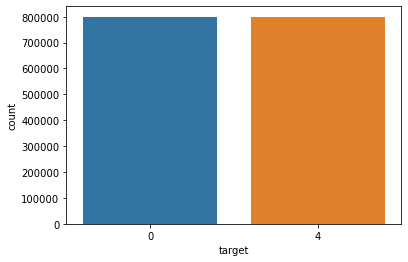

In [12]:
dataset_df = pd.read_csv(dataset, names=columns, encoding="latin-1")
dataset_df.info()
sns.countplot(dataset_df[label_column])
dataset_df.head()

### Data cleaning

#### Labels

/Users/nikolaystanishev/miniforge3/envs/abridge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


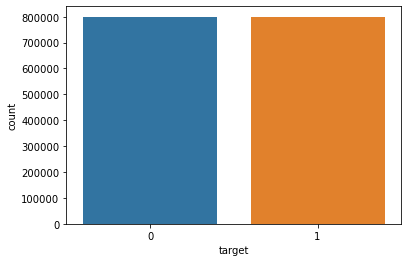

In [13]:
le = LabelEncoder()
dataset_df[label_column] = le.fit_transform(dataset_df[label_column])
sns.countplot(dataset_df[label_column])
dataset_df.head()

#### Data

##### Visualization

In [14]:
def visualize(df):
    dataset_positive = df[df[label_column]==1]
    dataset_negative = df[df[label_column]==0]
    data = " ".join(tweet for tweet in df[data_column])
    data_positive = " ".join(tweet for tweet in dataset_positive[data_column])
    data_negative = " ".join(tweet for tweet in dataset_negative[data_column])

    fig, ax = plt.subplots(3, 1, figsize  = (30,30))

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data)
    wordcloud_positive = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data_positive)
    wordcloud_negative = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data_negative)

    # Display the generated image:
    ax[0].imshow(wordcloud, interpolation='bilinear')
    ax[0].set_title('Data', fontsize=30)
    ax[0].axis('off')
    ax[1].imshow(wordcloud_positive, interpolation='bilinear')
    ax[1].set_title('Positive data',fontsize=30)
    ax[1].axis('off')
    ax[2].imshow(wordcloud_negative, interpolation='bilinear')
    ax[2].set_title('Negative data',fontsize=30)
    ax[2].axis('off')

In [15]:
# visualize(dataset_df)

##### Cleaning

In [16]:
PUNCUATION_LIST = list(string.punctuation)

def remove_urls(text):
    text = re.sub(r'https?:\/\/\S+', '', text)
    return re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', text)

def remove_placeholders(text):
    text = re.sub(r'{link}', '', text)
    return re.sub(r"\[video\]", '', text)

def remove_html_references(text):
    return re.sub(r'&[a-z]+;', '', text)

def remove_non_letter_characters(text):
    return re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', text)

def remove_mentions(text):
    return re.sub(r'@mention', '', text)

def remove_digits(text):
    return re.sub('[0-9]+', '', text)

def expand_contractions(text):
    return contractions.fix(text)

def remove_punctuation(text):
    return "".join([char for char in text if char not in PUNCUATION_LIST])

In [17]:
columns.remove(data_column)
columns.remove(label_column)
dataset_df = dataset_df.drop(columns, axis=1)

dataset_df[data_column] = dataset_df[data_column].str.lower()
dataset_df[data_column] = dataset_df[data_column].apply(remove_urls)
dataset_df[data_column] = dataset_df[data_column].apply(remove_placeholders)
dataset_df[data_column] = dataset_df[data_column].apply(remove_html_references)
dataset_df[data_column] = dataset_df[data_column].apply(remove_non_letter_characters)
dataset_df[data_column] = dataset_df[data_column].apply(remove_mentions)
dataset_df[data_column] = dataset_df[data_column].apply(remove_digits)
dataset_df[data_column] = dataset_df[data_column].apply(expand_contractions)
dataset_df[data_column] = dataset_df[data_column].apply(remove_punctuation)

dataset_df.head()

,target,text
0,0,switchfoot awww that is a bummer you should...
1,0,is upset that he cannot update his facebook by...
2,0,kenichan i dived many times for the ball manag...
3,0,my whole body feels itchy and like its on fire
4,0,nationwideclass no it is not behaving at all i...


##### Visualize

In [18]:
# visualize(dataset_df)

##### Tokenization

In [19]:
tknzr = TweetTokenizer()
dataset_df[data_column] = dataset_df[data_column].apply(tknzr.tokenize)

dataset_df.head()

,target,text
0,0,"[switchfoot, awww, that, is, a, bummer, you, s..."
1,0,"[is, upset, that, he, cannot, update, his, fac..."
2,0,"[kenichan, i, dived, many, times, for, the, ba..."
3,0,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"[nationwideclass, no, it, is, not, behaving, a..."


##### Remove stopwords

In [20]:
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
dataset_df[data_column] = dataset_df[data_column].apply(remove_stopwords)
dataset_df.head()

,target,text
0,0,"[switchfoot, awww, bummer, shoulda, got, david..."
1,0,"[upset, cannot, update, facebook, texting, mig..."
2,0,"[kenichan, dived, many, times, ball, managed, ..."
3,0,"[whole, body, feels, itchy, like, fire]"
4,0,"[nationwideclass, behaving, mad, cannot, see]"


In [21]:
max(dataset_df[data_column].apply(lambda x: len(x)))

34

##### Stemming and Lammitization

In [22]:
ps = PorterStemmer()
wn = WordNetLemmatizer()

def stemming(text):
    return [ps.stem(word) for word in text]

def lemmatization(text):
    return [wn.lemmatize(word) for word in text]

In [23]:
dataset_df[data_column] = dataset_df[data_column].apply(stemming)
dataset_df[data_column] = dataset_df[data_column].apply(lemmatization)

dataset_df.head()

,target,text
0,0,"[switchfoot, awww, bummer, shoulda, got, david..."
1,0,"[upset, cannot, updat, facebook, text, might, ..."
2,0,"[kenichan, dive, mani, time, ball, manag, save..."
3,0,"[whole, bodi, feel, itchi, like, fire]"
4,0,"[nationwideclass, behav, mad, cannot, see]"


### Data preparation

#### Split

In [24]:
X = dataset_df[data_column]
Y = dataset_df[label_column]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

In [25]:
max_len = 32
tok = Tokenizer()
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(sequences, maxlen=max_len, padding="post")

sequences = tok.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(sequences, maxlen=max_len, padding="post")

In [26]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(1360000, 32)
(1360000,)
(240000, 32)
(240000,)


In [27]:
np.save('../datasets/sentiment140/processed/02/X_train.npy', X_train)
np.save('../datasets/sentiment140/processed/02/Y_train.npy', Y_train)
np.save('../datasets/sentiment140/processed/02/X_test.npy', X_test)
np.save('../datasets/sentiment140/processed/02/Y_test.npy', Y_test)

In [28]:
X_train

array([[     1,     67,    824, ...,      0,      0,      0],
       [   312,      3,    404, ...,      0,      0,      0],
       [    90,     78,     27, ...,      0,      0,      0],
       ...,
       [580621,   2146,    137, ...,      0,      0,      0],
       [108411,   1103,   1327, ...,      0,      0,      0],
       [   536,    316,   2785, ...,      0,      0,      0]], dtype=int32)